# NN2_NEW_NEW_NEW

Before Best:
- MLP3 (256 → 256 → 128 → 1)
- no batch normalisation
- batch size 1024
- **CosineAnnealingLR schedule**

Now (idea: same arquitecture, better optimizaion):

- define smaller* lr min (eta_min=5e-8)
- longer epoch 2000
- double prescision (float64)

(Also try: MLP4: 512 → 512 → 256 → 1)


*before it went to zero but maybe too fast (lr=0  <--> weights frozen)



In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/rafael/miniforge3/envs/classy-env/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/rafael/miniforge3/envs/classy-env/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/rafael/miniforge3/envs/classy-env/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/rafael/miniforge3/envs/classy-env/lib/python3.10/site-packages/traitlets/config/

-----------------------------
### 1. Loading and preprocessing data
-----------------------------

In [44]:
df = pd.read_csv("DEF_-02+02_accepted_n18.csv") # change filename AFTER!!!
print(len(df))
X = df.iloc[:, :4].values  # -> np.ndarray -> (infer # filas, 4 column)
y = df.iloc[:, 4].values.reshape(-1, 1)*100 # we want 100 x theta_star

135826


$$x \rightarrow x'=\frac{x-\mu_x}{\sigma_x}$$
$$y \rightarrow  y'=\frac{y-\mu_y}{\sigma_y}$$

In [46]:
# compute mean in "files" direction (for each feature and target)
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)
y_norm = (y - y.mean(axis=0)) / y.std(axis=0)

# we store these for later use in predictions (normalization of input) and denormalization of output
y_mean = float(y.mean(axis=0))
y_std = float(y.std(axis=0))    
X_mean = X.mean(axis=0)    # no longer float since multiple features
X_std = X.std(axis=0)   
 
print("X mean:", X_mean)
print("X std:", X_std)
print("y mean:", y_mean)
print("y std:", y_std)  

# Convert to tensors (avoid requiring NumPy support in this torch build)
X_tensor = torch.tensor(X_norm.tolist(), dtype=torch.float64)
y_tensor = torch.tensor(y_norm.tolist(), dtype=torch.float64)

#X_tensor = torch.tensor(X_norm, dtype=torch.float64)
#y_tensor = torch.tensor(y_norm, dtype=torch.float64)


class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = RegressionDataset(X_tensor, y_tensor)


# Split dataset
N = len(dataset)
train_size = int(0.80 * N)
val_size = int(0.15 * N)
test_size = N - train_size - val_size

train_set, val_set, Test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=1024, shuffle=True)  # modified 32->128
val_loader   = DataLoader(val_set, batch_size=1024, shuffle=False)
test_loader  = DataLoader(Test_set, batch_size=1024, shuffle=False)


/var/folders/1b/_xbchkbd3vdgjnyj5vwm5x6m0000gn/T/ipykernel_12309/1385142912.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_mean = float(y.mean(axis=0))
/var/folders/1b/_xbchkbd3vdgjnyj5vwm5x6m0000gn/T/ipykernel_12309/1385142912.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_std = float(y.std(axis=0))


X mean: [ 2.25880561e-02  1.40001707e-01  8.68740558e-01 -2.12457082e-05]
X std: [0.00422967 0.03463927 0.17656861 0.11546451]
y mean: 1.191910774737084
y std: 0.42762638182997853


#### debug1

In [12]:
# Check for NaN values in original data
print("=" * 50)
print("CHECKING FOR NaN VALUES IN RAW DATA")
print("=" * 50)

print(f"\nOriginal X shape: {X.shape}")
print(f"Original y shape: {y.shape}")

print(f"\nX has NaN values: {np.isnan(X).any()}")
print(f"y has NaN values: {np.isnan(y).any()}")

if np.isnan(X).any():
    nan_count_X = np.isnan(X).sum()
    print(f"  → Total NaN values in X: {nan_count_X}")
    print(f"  → NaN per column: {np.isnan(X).sum(axis=0)}")
    print(f"  → Row indices with NaN: {np.where(np.isnan(X).any(axis=1))[0]}")

if np.isnan(y).any():
    nan_count_y = np.isnan(y).sum()
    print(f"  → Total NaN values in y: {nan_count_y}")
    print(f"  → Row indices with NaN: {np.where(np.isnan(y))[0]}")

# Check for inf values
print(f"\nX has Inf values: {np.isinf(X).any()}")
print(f"y has Inf values: {np.isinf(y).any()}")

# Check normalization
print(f"\nX_norm has NaN: {np.isnan(X_norm).any()}")
print(f"y_norm has NaN: {np.isnan(y_norm).any()}")

if np.isnan(X_norm).any():
    print(f"  → NaN count in X_norm: {np.isnan(X_norm).sum()}")
if np.isnan(y_norm).any():
    print(f"  → NaN count in y_norm: {np.isnan(y_norm).sum()}")

# Check X_std for zeros (division by zero)
print(f"\nX_std values: {X_std}")
print(f"X_std has zeros: {(X_std == 0).any()}")
print(f"y_std value: {y_std}")
print(f"y_std is zero: {y_std == 0}")

print("=" * 50)

CHECKING FOR NaN VALUES IN RAW DATA

Original X shape: (169790, 4)
Original y shape: (169790, 1)

X has NaN values: False
y has NaN values: True
  → Total NaN values in y: 1
  → Row indices with NaN: [84954]

X has Inf values: False
y has Inf values: False

X_norm has NaN: False
y_norm has NaN: True
  → NaN count in y_norm: 169790

X_std values: [0.00422964 0.04330088 0.17656965 0.11546575]
X_std has zeros: False
y_std value: nan
y_std is zero: False


In [15]:
# y at index value: 84954
y[84953],y[84954],y[84955]

(array([0.86735944]), array([nan]), array([1.44923545]))

#### debug2

<Figure size 600x300 with 0 Axes>

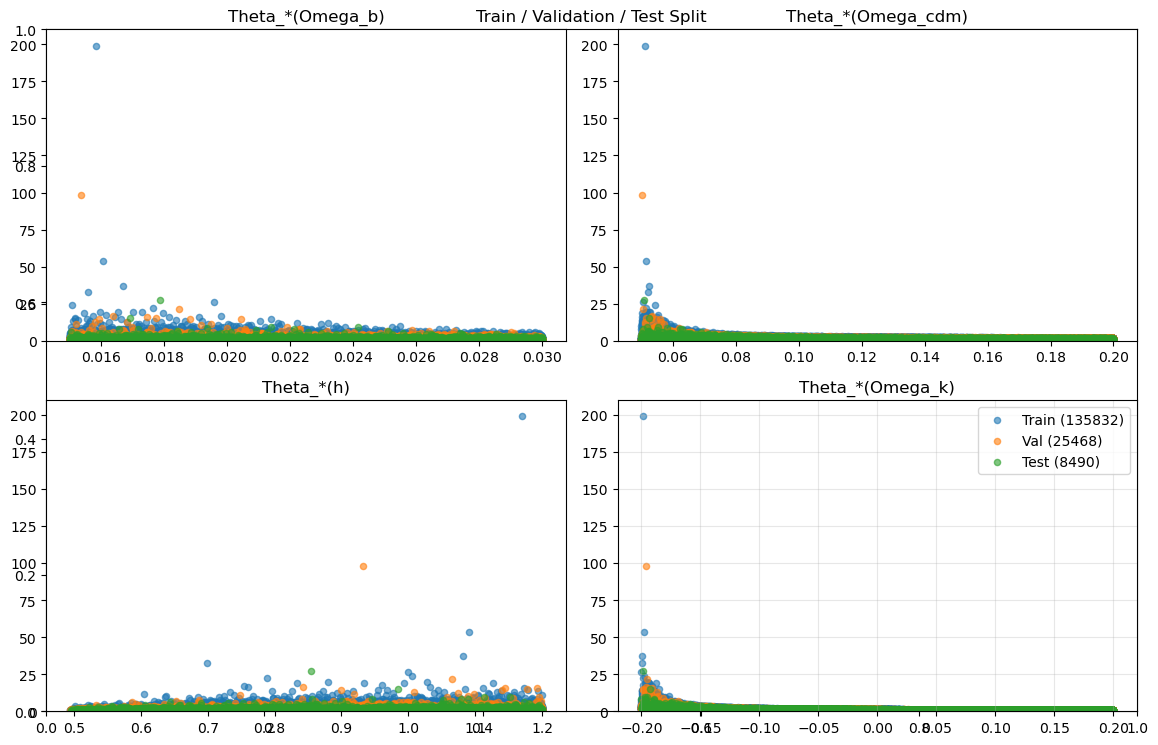

In [92]:
# Extract indices and data from each split
train_indices = train_set.indices
val_indices = val_set.indices
test_indices = Test_set.indices

X_train = X[train_indices]
y_train = y[train_indices]

X_val = X[val_indices]
y_val = y[val_indices]

X_test = X[test_indices]
y_test = y[test_indices]

# Plot the three sets
plt.figure(figsize=(6, 3))

params = ["Omega_b", "Omega_cdm", "h", "Omega_k"]
plt.figure(figsize=(12, 8))
plt.title("Train / Validation / Test Split")
for i, p in enumerate(params):
    plt.subplot(2, 2, i+1)
    plt.scatter(X_train[:,i], y_train, s=20, alpha=0.6, label=f"Train ({len(train_indices)})")
    plt.scatter(X_val[:,i], y_val, s=20, alpha=0.6, label=f"Val ({len(val_indices)})")
    plt.scatter(X_test[:,i],  y_test, s=20, alpha=0.6, label=f"Test ({len(test_indices)})")
    plt.title('Theta_*('+p+')')
    plt.ylim(0,210)

plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


<Figure size 600x300 with 0 Axes>

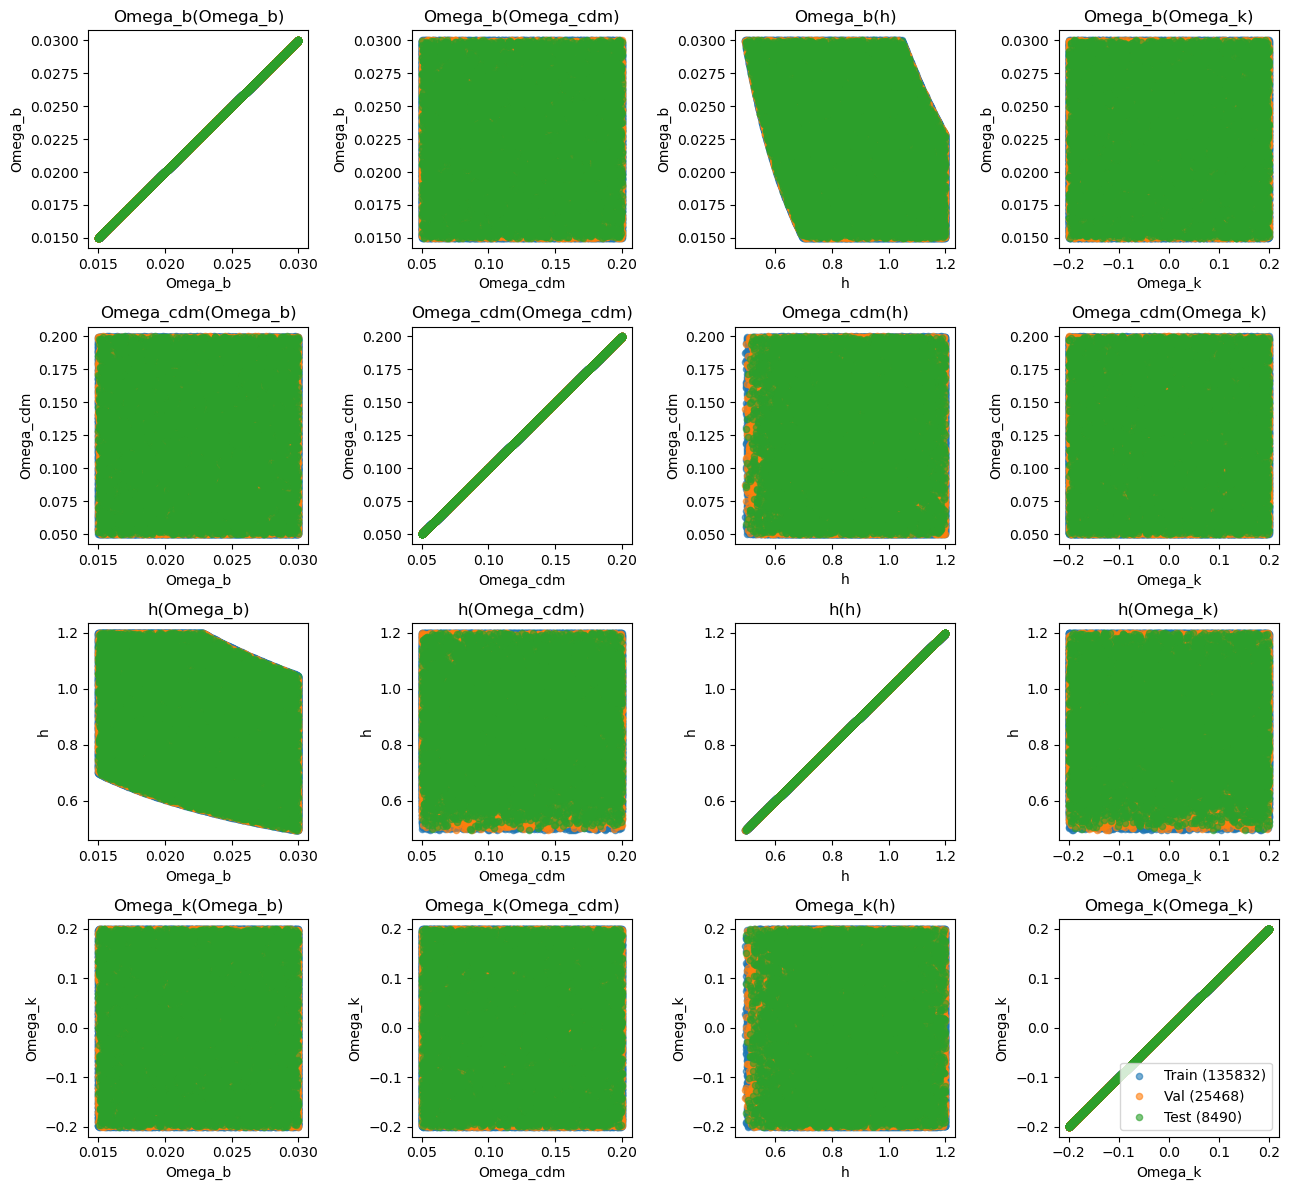

In [ ]:
plt.figure(figsize=(6, 3))

params = ["Omega_b", "Omega_cdm", "h", "Omega_k"]
plt.figure(figsize=(13, 12))
count=1
for j in range(0,4):
    for i, p in enumerate(params):
        plt.subplot(4, 4, count)
        plt.scatter(X_train[:,i], X_train[:,j], s=20, alpha=0.6, label=f"Train ({len(train_indices)})")
        plt.scatter(X_val[:,i], X_val[:,j], s=20, alpha=0.6, label=f"Val ({len(val_indices)})")
        plt.scatter(X_test[:,i],  X_test[:,j] , s=20, alpha=0.6, label=f"Test ({len(test_indices)})")
        plt.xlabel(p)
        plt.ylabel(params[j])
        plt.title(params[j]+'('+p+')')
        count+=1

plt.legend()

plt.tight_layout()
plt.show()


### data split plot

<Figure size 600x300 with 0 Axes>

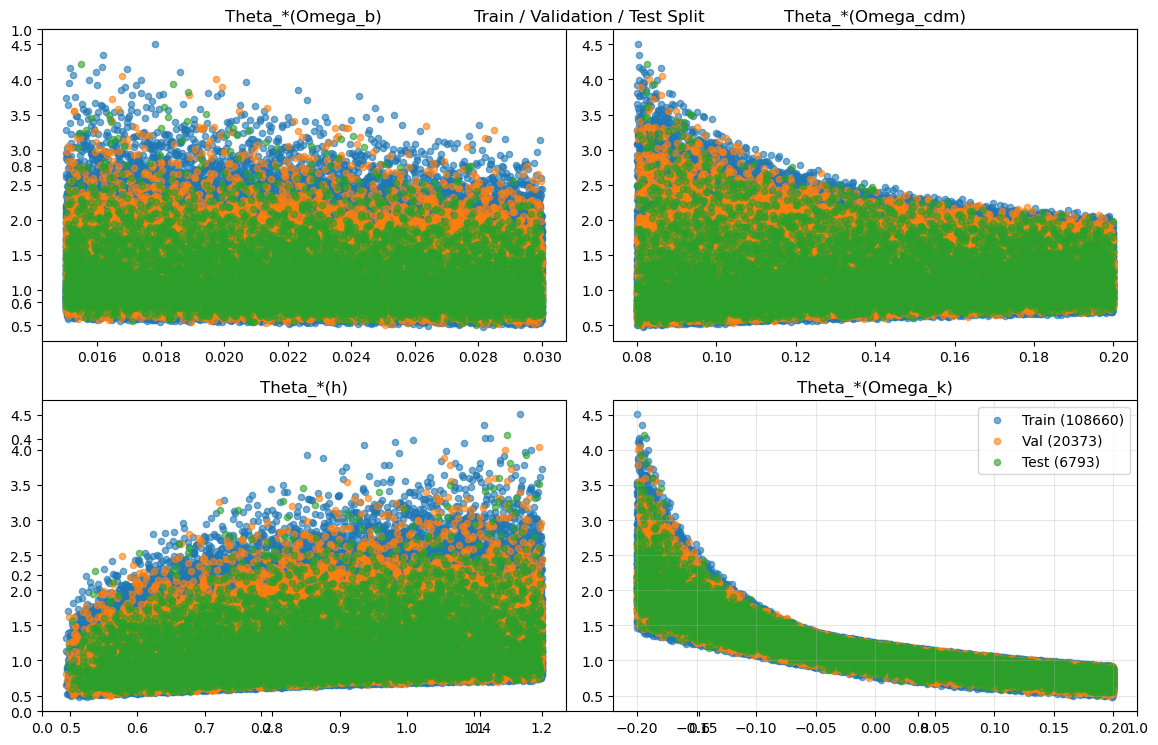

In [47]:
# Extract indices and data from each split
train_indices = train_set.indices
val_indices = val_set.indices
test_indices = Test_set.indices

X_train = X[train_indices]
y_train = y[train_indices]

X_val = X[val_indices]
y_val = y[val_indices]

X_test = X[test_indices]
y_test = y[test_indices]

# Plot the three sets
plt.figure(figsize=(6, 3))

params = ["Omega_b", "Omega_cdm", "h", "Omega_k"]
plt.figure(figsize=(12, 8))
plt.title("Train / Validation / Test Split")
for i, p in enumerate(params):
    plt.subplot(2, 2, i+1)
    plt.scatter(X_train[:,i], y_train, s=20, alpha=0.6, label=f"Train ({len(train_indices)})")
    plt.scatter(X_val[:,i], y_val, s=20, alpha=0.6, label=f"Val ({len(val_indices)})")
    plt.scatter(X_test[:,i],  y_test, s=20, alpha=0.6, label=f"Test ({len(test_indices)})")
    plt.title('Theta_*('+p+')')

plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


makes sence, given Omega_b, theta_star varies depending on other parameter values

we should maybe cut off ranges that give high values for theta_* (does it even make scence for it to be bigger thann 2pi? no)

<Figure size 600x300 with 0 Axes>

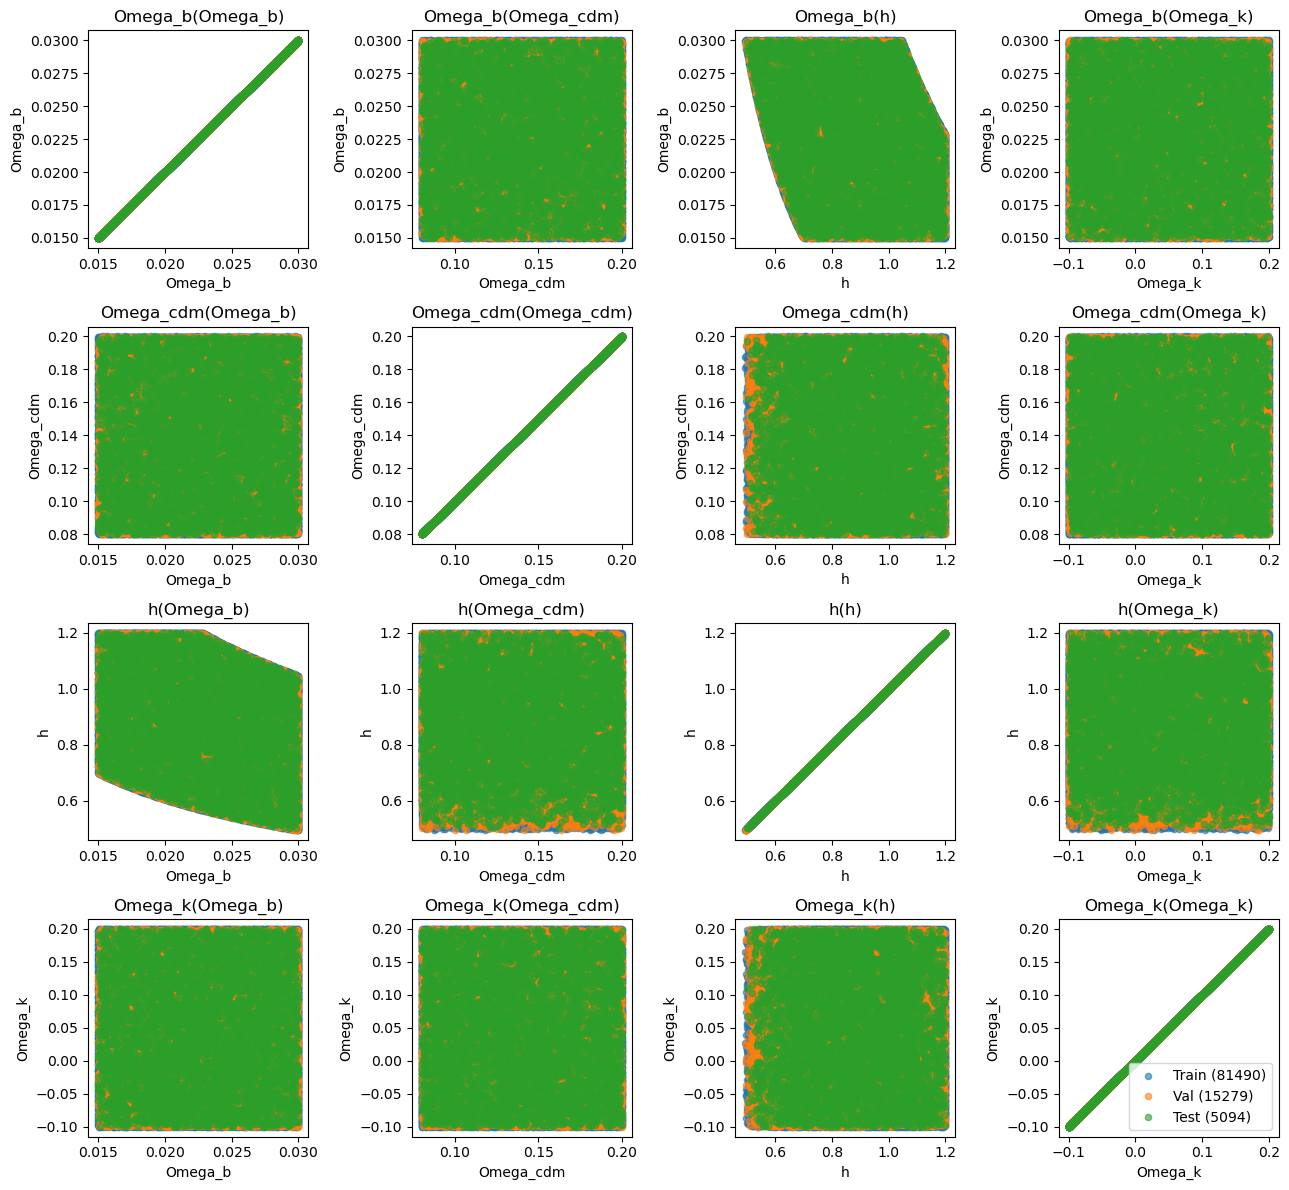

In [99]:
plt.figure(figsize=(6, 3))

params = ["Omega_b", "Omega_cdm", "h", "Omega_k"]
plt.figure(figsize=(13, 12))
count=1
for j in range(0,4):
    for i, p in enumerate(params):
        plt.subplot(4, 4, count)
        plt.scatter(X_train[:,i], X_train[:,j], s=20, alpha=0.6, label=f"Train ({len(train_indices)})")
        plt.scatter(X_val[:,i], X_val[:,j], s=20, alpha=0.6, label=f"Val ({len(val_indices)})")
        plt.scatter(X_test[:,i],  X_test[:,j] , s=20, alpha=0.6, label=f"Test ({len(test_indices)})")
        plt.xlabel(p)
        plt.ylabel(params[j])
        plt.title(params[j]+'('+p+')')
        count+=1

plt.legend()

plt.tight_layout()
plt.show()


-----------------------------
### 2. NN 
-----------------------------

In [6]:
class PreciseMLP3(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(4, 256),
            nn.GELU(),

            nn.Linear(256, 256),
            nn.GELU(),

            nn.Linear(256, 128),
            nn.GELU(),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)


In [7]:
class PreciseMLP4(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(4, 512),
            nn.GELU(),

            nn.Linear(512, 512),
            nn.GELU(),

            nn.Linear(512, 256),
            nn.GELU(),

            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x)


-----------------------------
### 3. NN training
-----------------------------

In [8]:
def train_one_model2(model, train_loader, val_loader, epochs=300, lr=1e-3):
    criterion = nn.MSELoss()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=0.0
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=epochs, eta_min=5e-8)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # ----- Training -----
        model.train()
        total_train_loss = 0
        count_train_batches = 0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            count_train_batches += 1

        total_train_loss /= count_train_batches

        # ----- Validation -----
        model.eval()
        total_val_loss = 0
        count_val_batches = 0

        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                total_val_loss += criterion(pred, yb).item()
                count_val_batches += 1

        total_val_loss /= count_val_batches

        # ----- Scheduler step (IMPORTANT) -----
        scheduler.step()

        if epoch % 50 == 0 or epoch > epochs - 10:
            print(
                f"Epoch {epoch:4d} | "
                f"LR = {scheduler.get_last_lr()[0]:.3e} | "
                f"Train = {total_train_loss:.3e} | "
                f"Val = {total_val_loss:.3e}"
            )

        train_losses.append(total_train_loss)
        val_losses.append(total_val_loss)

        # Optional: monitor LR
        # print(f"Epoch {epoch}: LR = {scheduler.get_last_lr()[0]:.3e}")

    return model, train_losses, val_losses


--------

In [10]:
n_epochs =2000

In [29]:
PreciseModel3 = PreciseMLP3().double()
PreciseModel3, precise_train_loss3, precise_val_loss3 = train_one_model2(PreciseModel3, train_loader, val_loader, epochs=n_epochs, lr=1e-3)


torch.save({
    'model_state_dict': PreciseModel3.state_dict(),
    'train_loss': precise_train_loss3,
    'val_loss': precise_val_loss3
}, "MLP3_with_history.pth")

print("Model and training history saved successfully!")

Epoch    0 | LR = 1.000e-03 | Train = 7.570e-02 | Val = 1.485e-03
Epoch   50 | LR = 9.984e-04 | Train = 1.947e-05 | Val = 4.970e-06
Epoch  100 | LR = 9.937e-04 | Train = 2.306e-05 | Val = 4.519e-05
Epoch  150 | LR = 9.860e-04 | Train = 1.042e-05 | Val = 1.701e-06
Epoch  200 | LR = 9.753e-04 | Train = 4.382e-06 | Val = 7.472e-07
Epoch  250 | LR = 9.616e-04 | Train = 2.200e-06 | Val = 2.561e-06
Epoch  300 | LR = 9.451e-04 | Train = 6.051e-07 | Val = 7.698e-07
Epoch  350 | LR = 9.259e-04 | Train = 8.474e-07 | Val = 8.133e-07
Epoch  400 | LR = 9.041e-04 | Train = 3.692e-06 | Val = 1.224e-06
Epoch  450 | LR = 8.797e-04 | Train = 1.754e-06 | Val = 1.546e-06
Epoch  500 | LR = 8.530e-04 | Train = 4.123e-06 | Val = 6.864e-06
Epoch  550 | LR = 8.241e-04 | Train = 1.275e-06 | Val = 2.408e-06
Epoch  600 | LR = 7.933e-04 | Train = 2.237e-06 | Val = 2.890e-06
Epoch  650 | LR = 7.606e-04 | Train = 2.326e-06 | Val = 2.788e-06
Epoch  700 | LR = 7.263e-04 | Train = 3.603e-07 | Val = 1.641e-07
Epoch  750

In [30]:
PreciseModel4 = PreciseMLP4().double()
PreciseModel4, precise_train_loss4, precise_val_loss4 = train_one_model2(PreciseModel4, train_loader, val_loader, epochs=n_epochs, lr=1e-3)


torch.save({
    'model_state_dict': PreciseModel4.state_dict(),
    'train_loss': precise_train_loss4,
    'val_loss': precise_val_loss4
}, "MLP4_with_history.pth")

print("Model and training history saved successfully!")

Epoch    0 | LR = 1.000e-03 | Train = 4.391e-02 | Val = 6.918e-04
Epoch   50 | LR = 9.984e-04 | Train = 1.007e-05 | Val = 2.188e-06
Epoch  100 | LR = 9.937e-04 | Train = 2.080e-04 | Val = 2.967e-05
Epoch  150 | LR = 9.860e-04 | Train = 4.017e-05 | Val = 2.562e-06
Epoch  200 | LR = 9.753e-04 | Train = 1.174e-05 | Val = 1.139e-05
Epoch  250 | LR = 9.616e-04 | Train = 8.718e-06 | Val = 1.905e-06
Epoch  300 | LR = 9.451e-04 | Train = 4.337e-07 | Val = 4.313e-06
Epoch  350 | LR = 9.259e-04 | Train = 4.240e-06 | Val = 7.885e-07
Epoch  400 | LR = 9.041e-04 | Train = 1.972e-07 | Val = 2.235e-07
Epoch  450 | LR = 8.797e-04 | Train = 7.566e-06 | Val = 1.869e-06
Epoch  500 | LR = 8.530e-04 | Train = 2.038e-06 | Val = 1.158e-06
Epoch  550 | LR = 8.241e-04 | Train = 3.603e-07 | Val = 2.459e-07
Epoch  600 | LR = 7.933e-04 | Train = 3.841e-06 | Val = 1.033e-06
Epoch  650 | LR = 7.606e-04 | Train = 3.344e-06 | Val = 9.949e-07
Epoch  700 | LR = 7.263e-04 | Train = 9.536e-06 | Val = 3.449e-06
Epoch  750

-------

#### (Loading model if kernel reset)

In [13]:
# Initialize the model
PreciseModel3 = PreciseMLP3().double()

# Load the checkpoint
checkpoint = torch.load("MLP3_with_history.pth")
PreciseModel3.load_state_dict(checkpoint['model_state_dict'])
PreciseModel3.eval()  # set to evaluation mode

# Retrieve training history
precise_train_loss3 = checkpoint['train_loss']
precise_val_loss3 = checkpoint['val_loss']

In [12]:
# Initialize the model
PreciseModel4 = PreciseMLP4().double()

# Load the checkpoint
checkpoint = torch.load("MLP4_with_history.pth")
PreciseModel4.load_state_dict(checkpoint['model_state_dict'])
PreciseModel4.eval()  # set to evaluation mode

# Retrieve training history
precise_train_loss4 = checkpoint['train_loss']
precise_val_loss4 = checkpoint['val_loss']

#### Loss plot

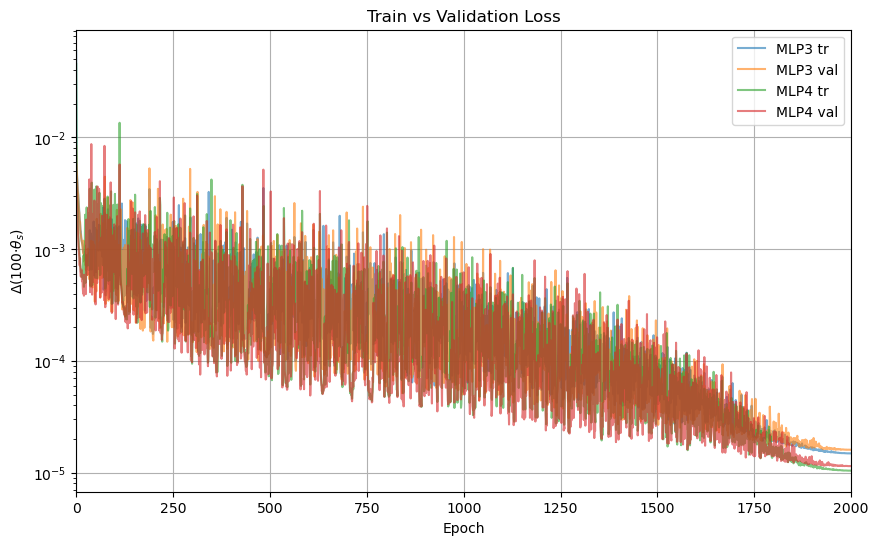

In [15]:
plt.figure(figsize=(10, 6))
epochs = range(1, len(precise_train_loss3) + 1)

plt.plot(y_std *np.sqrt(np.array(precise_train_loss3)), label=f"MLP3 tr", alpha=0.6)
plt.plot(y_std *np.sqrt(np.array(precise_val_loss3)), label=f"MLP3 val", alpha=0.6)

plt.plot(y_std *np.sqrt(np.array(precise_train_loss4)), label=f"MLP4 tr", alpha=0.6)
plt.plot(y_std *np.sqrt(np.array(precise_val_loss4)), label=f"MLP4 val", alpha=0.6)

plt.xlabel("Epoch")
plt.xlim(0, len(precise_train_loss3))
plt.ylabel(r"$\Delta (100 ·\theta_s)$")
# plt.yscale('log')
plt.title("Train vs Validation Loss")

# xlimits, ylimits
plt.xlim(0, 2000)
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


$ \Delta y = {\sigma_y}{\Delta y'}=\sigma_y \sqrt{Loss} $

In [39]:
y_std *np.sqrt(precise_val_loss3[-1]),y_std *np.sqrt(precise_val_loss4[-1])

(np.float64(1.6017424064621505e-05), np.float64(1.1445301172959006e-05))

-----------------------------
### 4. Ensemble training
-----------------------------

In [140]:

def train_NNensemble(M=5, n_neu1=5, n_neu2=5, epochs=300, lr=1e-3, Huang=False, preciseMLP=False):
    ensemble = []
    histories = []

    for i in range(M):
        print(f"\nTraining model {i+1}/{M}")
        if Huang:
            model = HuangNN(N=len(train_set), in_dim=1, out_dim=1)
        elif preciseMLP:
            model = PreciseMLP()
        else:
            model = simpleNN(n_neu1=n_neu1, n_neu2=n_neu2)
        trained_model, train_hist, val_hist = train_one_model(model, train_loader, val_loader, epochs=epochs, lr=lr)
        ensemble.append(trained_model)
        histories.append((train_hist, val_hist))

    return ensemble, histories


------

In [142]:
precise_ensemble10, precise_histories10 = train_NNensemble(M=10,epochs=900, preciseMLP=True)


Training model 1/10

Training model 2/10

Training model 3/10

Training model 4/10

Training model 5/10

Training model 6/10

Training model 7/10

Training model 8/10

Training model 9/10

Training model 10/10


In [143]:
#fine_tuned_ensemble10, fine_tuned_histories10 = train_NNensemble(M=10, n_neu1=100, n_neu2=4, epochs=900)

In [165]:
huang_ensemble10, huang_histories10 = train_NNensemble(M=10, epochs=900, Huang=True)


Training model 1/10
n_neu1 = 115
n_neu2 = 23


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x4 and 1x115)

In [144]:
#fine_tuned2_ensemble10, fine_tuned2_histories10 = train_NNensemble(M=10, n_neu1=91, n_neu2=4, epochs=900)

In [145]:
#new_huang_ensemble10, new_huang_histories10 = train_NNensemble(M=10, epochs=8, Huang=True)

-----------------------------
### 5.train vs validation Loss plot
-----------------------------

model tweaking, and model choosing


In [ ]:
plt.figure(figsize=(20, 6))
for i, (train_hist, val_hist) in enumerate(precise_histories10):
    plt.plot(train_hist, alpha=0.6, color='grey', label="Train" if i==0 else "")
    plt.plot(val_hist, alpha=0.6, color='red', label="Val" if i==0 else "")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')

# xlim
plt.xlim(0, 200)
plt.title("Huang Ensemble: rain vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


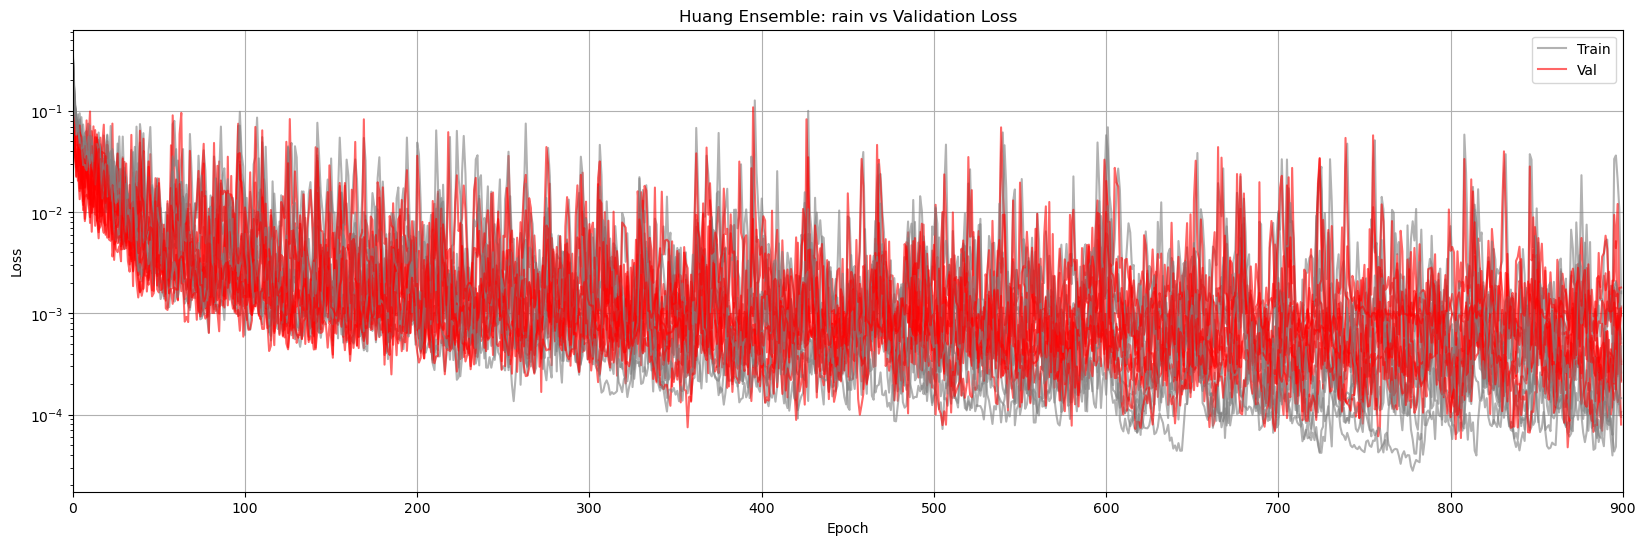

In [161]:
plt.figure(figsize=(20, 6))
for i, (train_hist, val_hist) in enumerate(precise_histories10):
    plt.plot(train_hist, alpha=0.6, color='grey', label="Train" if i==0 else "")
    plt.plot(val_hist, alpha=0.6, color='red', label="Val" if i==0 else "")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')

# xlim
plt.xlim(0, 900)
plt.title("Huang Ensemble: rain vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [164]:
170*500/(2.0*60*24)

29.51388888888889

choosing epoch cut-off

/var/folders/1b/_xbchkbd3vdgjnyj5vwm5x6m0000gn/T/ipykernel_1439/3799486368.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


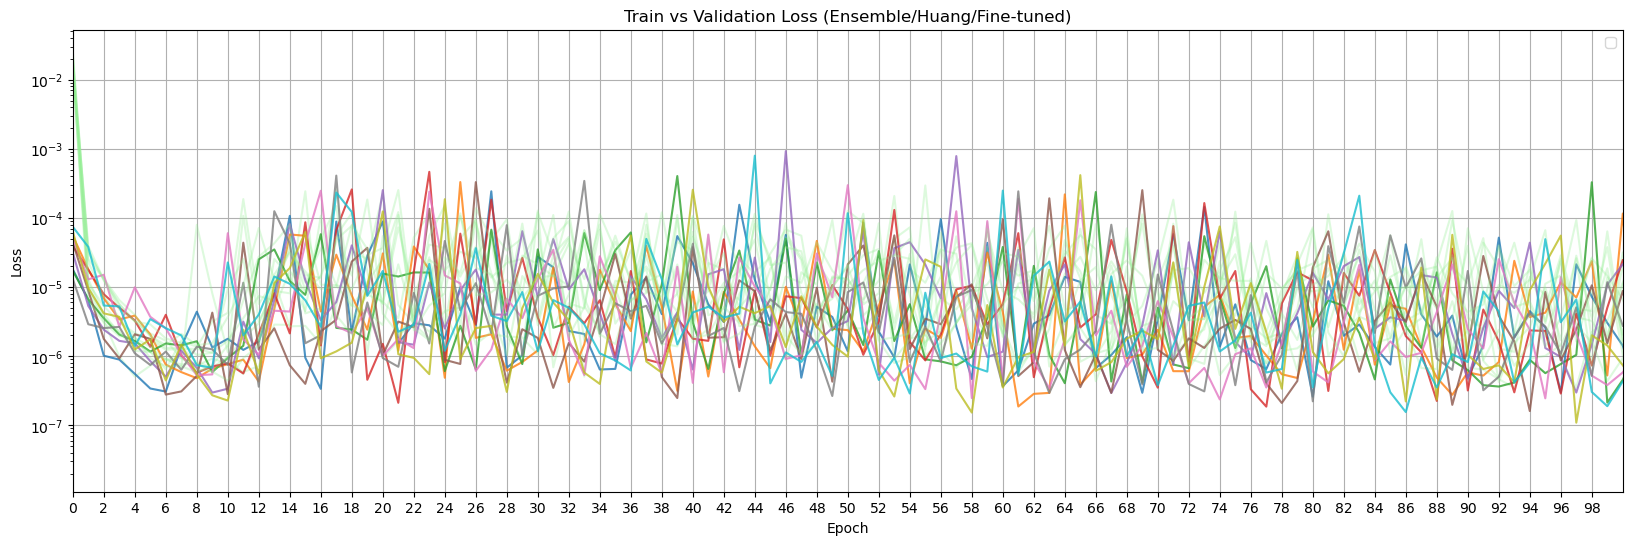

In [171]:
plt.figure(figsize=(20, 6))
for i, (train_hist, val_hist) in enumerate(new_huang_histories10):
    plt.plot(train_hist, alpha=0.3, color='lightgreen')
    plt.plot(val_hist, alpha=0.8)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')

# xticks
plt.xticks(np.arange(0, 100, 2))
plt.xlim(0, 100)
plt.title("Train vs Validation Loss (Ensemble/Huang/Fine-tuned)")
plt.legend()
plt.grid(True)
plt.show()


/var/folders/1b/_xbchkbd3vdgjnyj5vwm5x6m0000gn/T/ipykernel_11615/3799486368.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


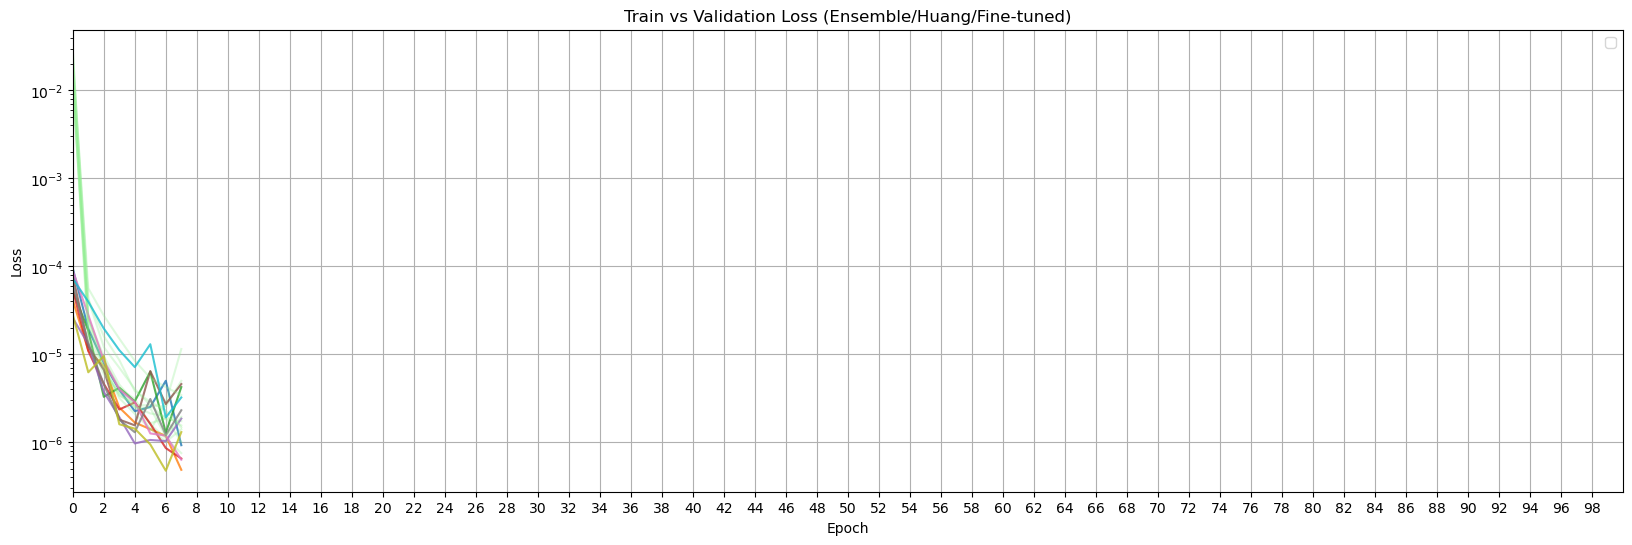

In [17]:
plt.figure(figsize=(20, 6))
for i, (train_hist, val_hist) in enumerate(new_huang_histories10):
    plt.plot(train_hist, alpha=0.3, color='lightgreen')
    plt.plot(val_hist, alpha=0.8)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')

# xticks
plt.xticks(np.arange(0, 100, 2))
plt.xlim(0, 100)
plt.title("Train vs Validation Loss (Ensemble/Huang/Fine-tuned)")
plt.legend()
plt.grid(True)
plt.show()


-----------------------------
### 9. furtther ENSEMBLE PREDICTION (MEAN, STD)
-----------------------------


In [46]:
def ensemble_predict(ensemble, x):
    global X_mean, X_std, y_mean, y_std
    x_normalized = (np.array(x).reshape(-1, 1) - X_mean) / X_std

    x_tensor = torch.tensor(x_normalized, dtype=torch.float32)

    preds = []
    for model in ensemble:
        model.eval()
        with torch.no_grad():
            pred = model(x_tensor)
            #print(type(pred))

            #preds.append(model(x_tensor).numpy().reshape(-1))
            #preds.append(pred.cpu().numpy().reshape(-1))  # Add .cpu() here
            #preds.append(pred.detach().cpu().numpy().reshape(-1))
            preds.append(pred.detach().cpu().tolist())


    preds = np.array(preds)  # shape (M, N)
    preds = preds*y_std+ y_mean # Denormalize 
    ensemble_mean = preds.mean(axis=0)
    ensemble_std  = preds.std(axis=0)

    return ensemble_mean, ensemble_std

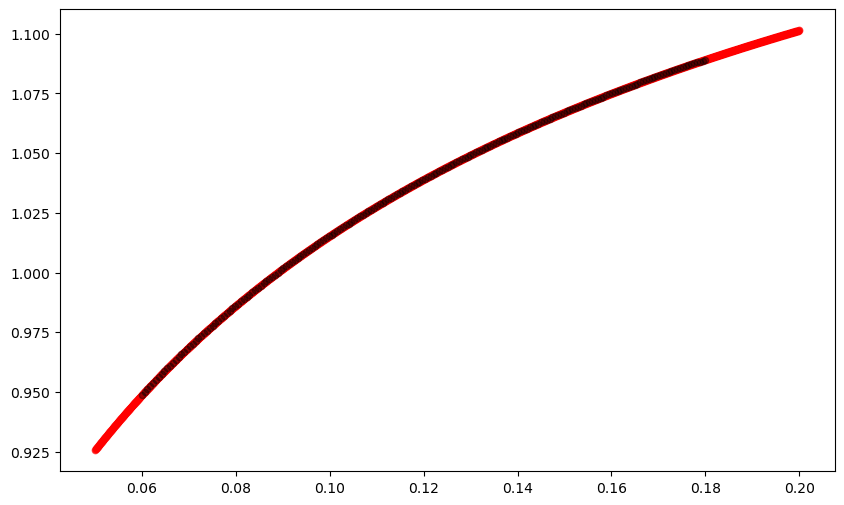

In [47]:
# Example prediction
xs = np.linspace(0.06, 0.18, 200)
mean, std = ensemble_predict(new_huang_ensemble10, xs) # USE ensemble1 if restart kernel


plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=20, alpha=0.1, label="Data", color='red')
plt.scatter(xs, mean, s=20, alpha=0.4, label="Data", color='k')


-----------------------------
### 6.Final Testing
-----------------------------

In [39]:
X_mean_t = torch.tensor(X_mean, dtype=torch.double)
X_std_t  = torch.tensor(X_std, dtype=torch.double)

y_mean_t = torch.tensor(y_mean, dtype=torch.double)
y_std_t  = torch.tensor(y_std, dtype=torch.double)

def extract_subset_to_numpy(subset):
    X_list = []
    y_list = []

    for x, y in subset:
        x = x * X_std_t + X_mean_t
        y = y * y_std_t + y_mean_t
        

        X_list.append(x.detach().cpu().tolist())
        y_list.append(y.detach().cpu().tolist())

    return np.array(X_list), np.array(y_list)


testing_X, testing_y = extract_subset_to_numpy(Test_set)

array([[ 0.02645482,  0.13404069,  1.0902223 ,  0.0568134 ],
       [ 0.02179437,  0.12988374,  1.07009968, -0.07584027],
       [ 0.01878599,  0.1092017 ,  1.13398925,  0.00543898],
       ...,
       [ 0.02197275,  0.11640772,  0.64083468,  0.12180452],
       [ 0.02920629,  0.13795283,  0.56720506,  0.1078882 ],
       [ 0.02219999,  0.12973467,  1.05728761,  0.02312466]],
      shape=(5094, 4))

In [ ]:
X_test_t = torch.tensor(testing_X, dtype=torch.double)

PreciseModel4.eval()
with torch.no_grad():
    y_pred = np.array(PreciseModel4(X_test_t).cpu().tolist())

-----

In [31]:
MAE = np.mean(np.abs(testing_y - y_pred))
MSE = np.mean((testing_y - y_pred)**2)
RMSE = np.sqrt(MSE)
print(f"MAE: {MAE}, MSE: {MSE}, RMSE: {RMSE}")

MAE: 0.8368135731515036, MSE: 0.7538563808750515, RMSE: 0.868249031600411


In [33]:
%time
X_test_t = torch.tensor([0.026748,	0.160473,	1.037008,	-0.006475], dtype=torch.double)

PreciseModel4.eval()
with torch.no_grad():
    y_pred = np.array(PreciseModel4(X_test_t).cpu().tolist())
    # denormalize 
    theta100 = y_pred*y_std+ y_mean

print(f"Prediction for : θ_s = {theta100[0]}")

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 6.91 μs
Prediction for : θ_s = 1.0513487303200848


In [36]:
#MAIN PLOT

y_pred = y_pred.ravel()

test_X = testing_X.ravel()

x_li = test_X[:,0].reshape(-1)
y_true_li = testing_y.reshape(-1)
y_pred_li = y_pred.reshape(-1)

fig = plt.figure(figsize=(15, 6))

# --- TOP PANEL --------------------------------------------------------
ax1 = plt.subplot2grid((2,1), (0,0))

ax1.errorbar(
    x_li, y_true_li, yerr=np.zeros_like(y_true_li),
    fmt='o', markersize=4, color='blue',
    ecolor='blue', elinewidth=1, capsize=1,
    label='CLASS'
)
ax1.errorbar(
    x_li, y_pred_li, yerr=np.zeros_like(y_true_li),
    fmt='o', markersize=3, color='red',
    ecolor='orange', elinewidth=1, capsize=1,
    label='MLP4'
)


# ax1.plot(
#     x_li, y_true_li,
#     color='blue' , linewidth=1,
#     label='Model'
# )

ax1.set_ylabel(r"$\theta_*$")
ax1.set_xlim(min(x_li), max(x_li))
ax1.legend()
ax1.grid(False)

# --- BOTTOM PANEL (RESIDUALS) ----------------------------------------
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

residuals = y_true_li - y_pred_li

ax2.errorbar(
    x_li, residuals, yerr=np.zeros_like(y_true_li),
    fmt='o', markersize=3, color='red',
    ecolor='orange'
    
    
    , elinewidth=1, capsize=2
)

ax2.axhline(0, color='blue', linewidth=3)

y_err_PLANCK = 0.0003
ax2.axhline(y_err_PLANCK, color='green', linewidth=2, label='Planck 2018 Uncertainty')
ax2.axhline(-y_err_PLANCK, color='green', linewidth=2)

ax2.set_ylabel(r"$\Delta 100 · \theta_*$")
ax2.set_xlabel(r"$\Omega_{cdm}$")
ax2.set_xlim(min(x_li), max(x_li))

ax2.legend()


plt.tight_layout()
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

ValueError: 'x' and 'y' must have the same size

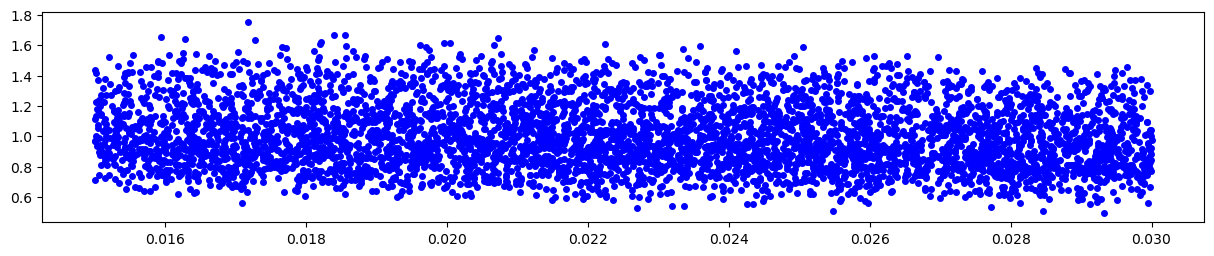

In [41]:
#MAIN PLOT

y_pred = y_pred.ravel()

#test_X = testing_X.ravel()

x_li = list(testing_X[:,0])
y_true_li = testing_y.reshape(-1)
y_pred_li = y_pred.reshape(-1)

fig = plt.figure(figsize=(15, 6))

# --- TOP PANEL --------------------------------------------------------
ax1 = plt.subplot2grid((2,1), (0,0))

ax1.errorbar(
    x_li, y_true_li, yerr=np.zeros_like(y_true_li),
    fmt='o', markersize=4, color='blue',
    ecolor='blue', elinewidth=1, capsize=1,
    label='CLASS'
)
ax1.errorbar(
    x_li, y_pred_li, yerr=np.zeros_like(y_true_li),
    fmt='o', markersize=3, color='red',
    ecolor='orange', elinewidth=1, capsize=1,
    label='MLP4'
)


# ax1.plot(
#     x_li, y_true_li,
#     color='blue' , linewidth=1,
#     label='Model'
# )

ax1.set_ylabel(r"$\theta_*$")
ax1.set_xlim(min(x_li), max(x_li))
ax1.legend()
ax1.grid(False)

# --- BOTTOM PANEL (RESIDUALS) ----------------------------------------
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

residuals = y_true_li - y_pred_li

ax2.errorbar(
    x_li, residuals, yerr=np.zeros_like(y_true_li),
    fmt='o', markersize=3, color='red',
    ecolor='orange'
    
    
    , elinewidth=1, capsize=2
)

ax2.axhline(0, color='blue', linewidth=3)

y_err_PLANCK = 0.0003
ax2.axhline(y_err_PLANCK, color='green', linewidth=2, label='Planck 2018 Uncertainty')
ax2.axhline(-y_err_PLANCK, color='green', linewidth=2)

ax2.set_ylabel(r"$\Delta 100 · \theta_*$")
ax2.set_xlabel(r"$\Omega_{cdm}$")
ax2.set_xlim(min(x_li), max(x_li))

ax2.legend()


plt.tight_layout()
plt.show()

 -----------------------------
### 8. Template for loading saved models
-----------------------------

In [20]:
import torch
import torch.nn as nn

# Make sure the model class is defined
class PreciseMLP4(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 512),
            nn.GELU(),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x)

# Initialize the model
PreciseModel4 = PreciseMLP4().double()

# Load the checkpoint
checkpoint = torch.load("precise_mlp4_with_history.pth")
PreciseModel4.load_state_dict(checkpoint['model_state_dict'])
PreciseModel4.eval()  # set to evaluation mode

# Retrieve training history
precise_train_loss4 = checkpoint['train_loss']
precise_val_loss4 = checkpoint['val_loss']

print("Model and training history loaded successfully!")


FileNotFoundError: [Errno 2] No such file or directory: 'precise_mlp4.pth'